In [ ]:
import scanpy as sc 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import numpy as np
import scipy
import os

from utils import plot_histogram
from var import *
from guide_assignment import *

In [2]:
#set seed to 0 for reproducibility of results
np.random.seed(0)

In [3]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/guide_assignment/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

## 1. Assessing extent of guide overassignment issue

In [4]:
#load raw anndata object
adata = sc.read_h5ad('/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/results/20230113_all_cells.h5ad')

In [5]:
#select all guides by selecting the names which do not start with ENSG in var_names
targeted_tf_guides = list(adata.var_names[~adata.var_names.str.startswith('ENSG')])
#use list comprehension to split targeted_tf_guides by '_' and select the first element of the list
targeted_tf = [x.split('_')[0] for x in targeted_tf_guides]

In [6]:
# Create a list of expected guides including the control guides 
expected_guides = [
    'AIRE',
    'ASCL1',
    'DLX1',
    'IRF3',
    'LHX6',
    'MAFB',
    'MYOD1',
    'NEUROG2',
    'OLIG2',
    'PROX1',
    'RORA',
    'RORB',
    'SATB2',
    'sgRNA1_SCP',
    'sgRNA6_SCP',
    'ONE_INTERGENIC_SITE_1194'
]

[i for i in expected_guides if i not in targeted_tf]

['sgRNA1_SCP', 'sgRNA6_SCP', 'ONE_INTERGENIC_SITE_1194']

In [7]:
#save counts in adata counts layer
adata.layers['counts'] = adata.X.copy()
#filter adata for cells with total_counts > 5000
adata_filtered = adata[adata.obs['total_counts'] > 5000].copy()

In [8]:
#filter adata_filtered for expected tf with regex
adata_filtered = adata_filtered[:, adata_filtered.var_names.str.contains('|'.join(expected_guides))].copy()

In [9]:
#normalize adata_filtered with scanpy
adata_filtered.layers["normalised"] = sc.pp.normalize_total(adata_filtered, target_sum=1e4, layer="counts", copy=True).X

In [10]:
#log1p transform adata_filtered
adata_filtered.layers["log1p_normalised"] = sc.pp.log1p(adata_filtered, layer="normalised", copy=True).X
adata_filtered.layers["log1p"] = sc.pp.log1p(adata_filtered, layer="counts", copy=True).X

### 1.1. guide UMI count distribution

In [11]:
dense_count_2d_arr = sparse_to_2d_arr(adata_filtered)
guide_frequency = count_guide_frequency(dense_count_2d_arr)

[[  0.   0. 374. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   2.   1.]
 [ 46.   6.   1. ...   0.   0.   1.]
 ...
 [  0.   0.   1. ...   0.   0.   0.]
 [  0.   0.   1. ...   0.   0.   3.]
 [  0.   1.   1. ...   0.   0.   0.]]


#### 1.1.1 guide UMI count histograms

In [ ]:
#plot barplot from pandas Series
tf_guides_series = pd.Series(
    np.array(adata_filtered.layers['counts'].mean(0)).flatten(),
    index=adata_filtered.var_names
)
fig, ax = plt.subplots()
tf_guides_series.plot.barh(
    figsize=(20,10)
    )
fig.subplots_adjust(left=0.5)
#adjust y axis to avoid overlap of text
ax.set_yticks(np.arange(len(tf_guides_series)))
fig.tight_layout()
#label x and y axis
plt.xlabel('average UMI count/cell')
plt.ylabel('sgRNA')

# plt.savefig(f'{figures_folder}{today}_tf_guides_barplot.pdf',bbox_inches='tight')

In [ ]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=100)
    plt.xlabel('normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    
    #plot adata.var_names for each gene as legend

    plt.legend(adata_filtered.var_names,bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    #set lower xlim to 1, to exclude zero values
    plt.gca().set_xlim(left=1)

    #log scale y axis
    plt.gca().set_yscale('log')
#save figure
# plt.savefig(f'{figures_folder}{today}_tf_guides_frequency.pdf',bbox_inches='tight')
# plt.close()

In [ ]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,50])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    #plt.gca().set_xlim(left=1)
# plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_1_50.pdf',bbox_inches='tight')

In [ ]:
#plot lineplot for each row in count_frequncy_arr
for x in range(0,guide_frequency.shape[1]):
    # plt.plot(np.arange(1,guide_frequency.shape[0]),guide_frequency[1:,x])
    plt.hist(guide_frequency[1:,x], bins=200)
    plt.xlabel('Normalised UMI count')
    
    plt.ylabel('log(# of cells)')
    #limit x axis to interval 1 and 100
    plt.xlim([1,100])

    #log scale y axis
    plt.gca().set_yscale('log')
    
    #set lower xlim to 1, to exclude zero values
    # plt.gca().set_xlim(left=1)
    # plt.savefig(f'{figures_folder}{today}_tf_guides_gene_frequency_interval_10_100.pdf',bbox_inches='tight')

### 1.2 Guide assignment

In [12]:
#assign pools based on experimental design
adata_filtered.var['guide_pool'] = adata_filtered.var_names.str.split('_').str[0]
#assign control guides to control pool
adata_filtered.var.loc[adata_filtered.var['guide_pool'].isin(['sgRNA1', 'sgRNA6', 'ONE']), 'guide_pool'] = 'non_activating'

#### 1.2.1 Guide fraction for guide pool

In [ ]:
def compute_guide_fraction(array):
    """
    Parameters
    ----------
    array : 2d array
    Returns
    -------
    guide_frac_per_cell : 2d array
        DESCRIPTION.
    Compute fraction per column to determine guide fraction of each cell
    """
    #compute fraction per column
    guide_frac_per_cell=array.T/array.sum(axis=1)
    guide_frac_per_cell=guide_frac_per_cell.T
    #sort fraction in ascending order for each row
    guide_frac_per_cell.sort(axis=0)
    #remove all zeros in a column 
    guide_frac_per_cell=guide_frac_per_cell[~np.all(guide_frac_per_cell == 0, axis = 1),:]
    return guide_frac_per_cell

In [ ]:
guide_frac_per_cell=compute_guide_fraction(dense_count_2d_arr)

In [ ]:
guide_pool_list = []
#calculate fraction of each guide pool
for pool in adata_filtered.var['guide_pool'].unique():

    #calculate fraction of each guide pool    
    idx = np.where(adata_filtered.var['guide_pool'] == pool)[0]
    tmp_frac = dense_count_2d_arr[:,idx].sum(axis=1)/dense_count_2d_arr.sum(axis=1)
    guide_pool_list.append(tmp_frac)
    tmp_frac.sort(axis=0)
    
    plt.plot(tmp_frac)
    #plot legend with short_name
    plt.legend(adata_filtered.var['guide_pool'].unique(),bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.xlabel('Cell index')
    
    plt.ylabel('Accumulative guide frequency')
# plt.savefig(f'{figures_folder}{today}_guide_pool_fraction_per_cell.pdf',bbox_inches='tight')

In [ ]:
#define frequency for 1d threshold here
guide_frac_threshold=0.5

In [ ]:
#create folder for figures if it does not exist 
hist_2d_freq_folder = os.path.join(figures_folder, 'hist2d_frequency/')

if not os.path.exists(hist_2d_freq_folder):
    os.makedirs(hist_2d_freq_folder)
#use divmod to plot subplots
n_col = 3
n_row = np.ceil(len(expected_guides)/n_col)
n_row = int(n_row)
#initialise figure with spacing between subplots
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 15),constrained_layout=True)

guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for n,short_name in enumerate(expected_guides):
    tmp_guides = guides[guides.str.contains(short_name)]



    
    if len(tmp_guides) == 2:
        #create empty list to store fraction of each guide pair
        curr_guide_pool = []
            
        for i,guide_name in enumerate(tmp_guides):
            tmp_adata=adata_filtered[:,adata_filtered.var_names.str.contains(guide_name)]
            #calculate fraction of each guide pair
            tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
            curr_guide_pool.append(tmp_frac)
            print(len(curr_guide_pool))

        #concatenate all fractions of each guide pair
        curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
        #convert to numpy array
        curr_guide_pool = np.array(curr_guide_pool)
        
        
        #plot scatter plot of guide pair fraction
        
        # axs[np.divmod(n, n_col)].hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
        #                 norm = colors.LogNorm())
        print(np.divmod(n, n_col))
        #plot scatter plot in different color based on guide_frac_threshold
        axs[np.divmod(n, n_col)].scatter(curr_guide_pool[curr_guide_pool[:,0]>guide_frac_threshold,0],curr_guide_pool[curr_guide_pool[:,0]>guide_frac_threshold,1],s=1,c='r')
        axs[np.divmod(n, n_col)].scatter(curr_guide_pool[curr_guide_pool[:,0]<=guide_frac_threshold,0],curr_guide_pool[curr_guide_pool[:,0]<=guide_frac_threshold,1],s=1,c='b')

        axs[np.divmod(n, n_col)].scatter(curr_guide_pool[:,0],curr_guide_pool[:,1],s=1)
        #add x and y label
        axs[np.divmod(n, n_col)].set_xlabel(f'{short_name}_guide_pair_1 frequency')
        axs[np.divmod(n, n_col)].set_ylabel(f'{short_name}_guide_pair_2 frequency')
    else:
        fig.delaxes(axs[np.divmod(n, n_col)])

        # #save figure
        # plt.savefig(f'{hist_2d_freq_folder}{today}_{short_name}_guide_pair_frequency.pdf',bbox_inches='tight')
            #remove empty subplots
    if n == len(expected_guides)-1:
        for i in range(n+1, n_col*n_row):
            fig.delaxes(axs[np.divmod(i, n_col)])

In [ ]:
#create empty list to store fraction of each guide pair
curr_guide_pool = []
fig,axs = plt.subplots()
    
for i,guide_name in enumerate(['RORA','non_activating']):
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == guide_name)[0]]
    print(tmp_adata.X.shape)
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
    curr_guide_pool.append(tmp_frac)
    print(len(curr_guide_pool))
    
#concatenate all fractions of each guide pair
curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
#convert to numpy array
curr_guide_pool = np.array(curr_guide_pool)


#plot scatter plot of guide pair fraction

plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                norm = colors.LogNorm())
#add x and y label
plt.xlabel(f'RORA_guide_pair_1 frequency')
plt.ylabel(f'control_guides frequency')
# #save figure
# plt.savefig(f'{hist_2d_freq_folder}{today}_RORA_guide_pair_frequency.pdf',bbox_inches='tight')

In [ ]:
#create empty list to store fraction of each guide pair
curr_guide_pool = []
fig,axs = plt.subplots()
    
for i,guide_name in enumerate(['RORB','non_activating']):
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == guide_name)[0]]
    print(tmp_adata.X.shape)
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)/adata_filtered.X.sum(axis=1)
    curr_guide_pool.append(tmp_frac)
    print(len(curr_guide_pool))
    
#concatenate all fractions of each guide pair
curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
#convert to numpy array
curr_guide_pool = np.array(curr_guide_pool)


#plot scatter plot of guide pair fraction

plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
                norm = colors.LogNorm())
#add x and y label
plt.xlabel(f'RORB_guide_pair_1 frequency')
plt.ylabel(f'control_guides frequency')

# plt.savefig(f'{hist_2d_freq_folder}{today}_RORB_guide_pair_frequency.pdf',bbox_inches='tight')

#### 1.2.3 Gaussian Mixture Model on guide count

In [13]:
#create empty column in adata_filtered.obs to store Gaussian mixture model assignment
adata_filtered.obs['gmm_pert_assignment'] = np.nan

In [17]:
adata_filtered.X.shape

(11814, 49)

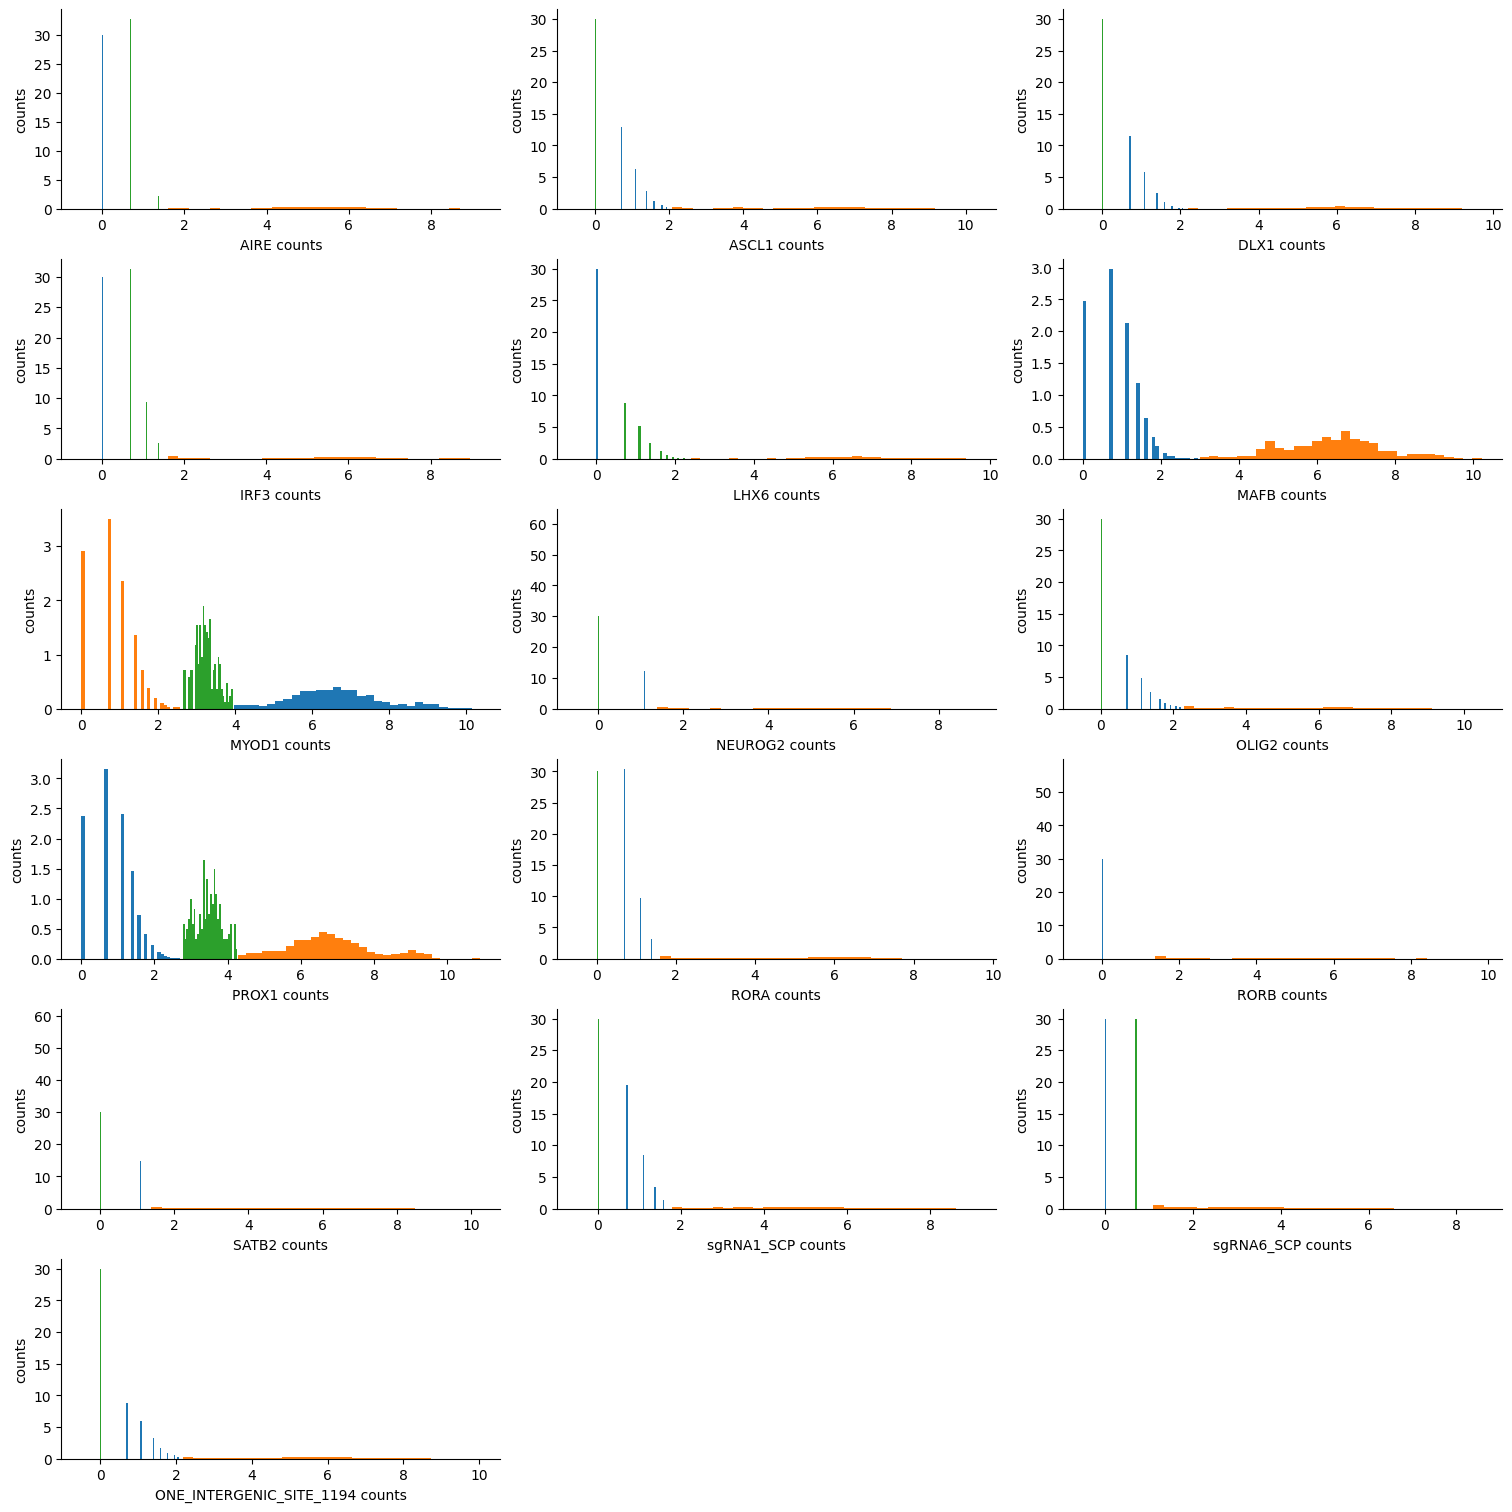

In [22]:
#Apply Gaussian mixture model to each guide pair and assign perturbation status without combinations

#filter adata_filtered for genes with min count of 1
sc.pp.filter_genes(adata_filtered, min_counts=1)

#create columns to count multiple count assignments
adata_filtered.obs['gmm_pert_assignment_multiple'] = np.nan
#create a np.array to add multiple count assignments per cell
multi_assignment_count=np.zeros(adata_filtered.X.shape[0])

#use divmod to plot subplots
n_col = 3
n_row = np.ceil(len(expected_guides)/n_col)
n_row = int(n_row)
#initialise figure with spacing between subplots
fig, axs = plt.subplots(n_row, n_col, figsize=(15, 15),constrained_layout=True)
#plot 2d histogram for each log1 p trasnformed summed guides
guides = adata_filtered.var_names.str.rstrip('_1|_2').unique()
for n,short_name in enumerate(expected_guides):


    tmp_adata=adata_filtered[:,adata_filtered.var_names.str.contains(short_name)]
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)
    #log1p transform
    tmp_frac = np.log1p(tmp_frac)
    #convert to numpy array
    curr_guide_pool = np.array(tmp_frac)

    #calculate Bayesian Gaussian Mixture Model
    from sklearn.mixture import BayesianGaussianMixture
    bgmm = BayesianGaussianMixture(n_components=3,weight_concentration_prior=1e-3, max_iter=1000, random_state=0, init_params='k-means++')
    bgmm.fit(curr_guide_pool)

    #get predicted labels
    labels = bgmm.predict(curr_guide_pool)

    #assign perturbation assignment to adata_filtered.obs
    max_weight_idx = np.argmax(bgmm.weights_)
    pert_label = np.unique(labels)[max_weight_idx]
    
    #assign cells with perturbation label to gmm_pert_assignment by mapping tmp_adata.obs_names to adata_filtered.obs_names
    #filter tmp_adata to only include cells with perturbation label
    boolean_label=labels==pert_label
    tmp_adata_filtered = tmp_adata[tmp_adata.obs_names[boolean_label]]
    #add labels to multi_assignment_count
    multi_assignment_count+=boolean_label.astype(int)
    adata_filtered.obs.loc[adata_filtered.obs_names.isin(tmp_adata_filtered.obs_names),'gmm_pert_assignment'] = short_name


    #color histogram based on predicted labels
    for i in range(0,len(np.unique(labels))):

        #use divmod to plot subplots
        axs[np.divmod(n, n_col)].hist(curr_guide_pool[labels==i,0],bins=30,density=True, color=f'C{i}')
        #add x and y label
        axs[np.divmod(n, n_col)].set_xlabel(f'{short_name} counts')
        axs[np.divmod(n, n_col)].set_ylabel('counts')

    #remove empty subplots
    if n == len(expected_guides)-1:
        for i in range(n+1, n_col*n_row):
            fig.delaxes(axs[np.divmod(i, n_col)])


Text(0, 0.5, 'counts')

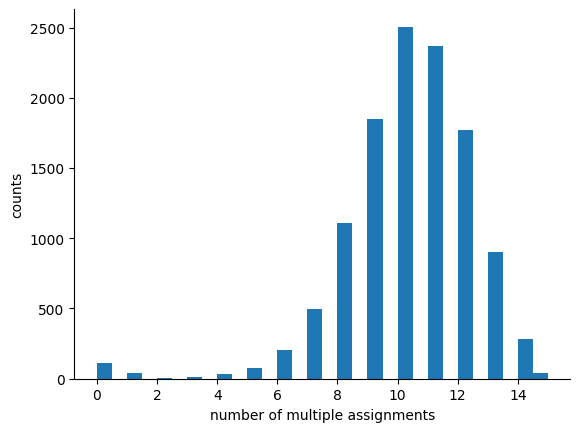

In [26]:
#plot histogram of multiple assignments
plt.hist(multi_assignment_count,bins=30)
plt.xlabel('number of multiple assignments')
plt.ylabel('counts')

In [ ]:
#plot Gaussian Mixture Model for guide combination

#create empty list to store fraction of each guide pair
curr_guide_pool = []
fig,axs = plt.subplots()
    
for i,guide_name in enumerate(['RORB','non_activating']):
    tmp_adata=adata_filtered[:,np.where(adata_filtered.var['guide_pool'] == guide_name)[0]]
    print(tmp_adata.X.shape)
    #calculate fraction of each guide pair
    tmp_frac = tmp_adata.X.sum(axis=1)
    #log1p transform
    tmp_frac = np.log1p(tmp_frac)
    curr_guide_pool.append(tmp_frac)
    print(len(curr_guide_pool))
    
#concatenate all fractions of each guide pair
curr_guide_pool = np.concatenate(curr_guide_pool,axis=1)
#convert to numpy array
curr_guide_pool = np.array(curr_guide_pool)

#compute Bayesian Gaussian Mixture Model
from sklearn.mixture import BayesianGaussianMixture
bgmm = BayesianGaussianMixture(n_components=2,weight_concentration_prior=1e-3, max_iter=1000, random_state=0,init_params='k-means++')
bgmm.fit(curr_guide_pool)
print(bgmm.weights_)
#get predicted labels
labels = bgmm.predict(curr_guide_pool)
print(np.unique(labels))


# #plot scatter plot of guide pair fraction

# plt.hist2d(curr_guide_pool[:,0],curr_guide_pool[:,1],bins=100,density=True, 
#                 norm = colors.LogNorm())

#plot scatter plot of curr_guide_pool based on predicted labels
for i in range(0,len(np.unique(labels))):
    plt.scatter(curr_guide_pool[labels==i,0],curr_guide_pool[labels==i,1],s=1)

#add x and y label
plt.xlabel(f'RORB_guide_pair_1 counts')
plt.ylabel(f'control_guides counts')

# plt.savefig(f'{hist_2d_freq_folder}{today}_RORB_guide_pair_frequency.pdf',bbox_inches='tight')

In [ ]:
adata_filtered.obs['perturbation_state'].value_counts()
#create a bar chart from the value counts of perturbation state
adata_filtered.obs['perturbation_state'].value_counts().plot.bar()
#add x and y label to bar chart
plt.xlabel('Perturbed genes')
plt.ylabel('# of cells')
#save figure in figures folder with today's date
plt.savefig(f'{figures_folder}/{today}_perturbation_state_barplot.pdf',dpi=300, bbox_inches='tight')


In [ ]:
#save adat_filter obs as csv file
adata_filtered.obs.to_csv(f'/lustre/scratch123/hgi/teams/parts/kl11/cell2state_tf_activation/data/crispra_data_exploration/{today}_perturbation_state.csv')
